In [441]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
import sklearn.model_selection

os.chdir(os.path.dirname(os.path.abspath(__file__)))

# データの読み込み
# 1.利用履歴データの読み込み
use_log = pd.read_csv("input/use_log.csv")
use_log.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [442]:
# 2.顧客行動データの読み込み
customer = pd.read_csv("input/join_customer_data.csv")
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_end_date           0
membership_period       0
dtype: int64

In [443]:
# クラスタリングで顧客をグループ化する
# 1.クラスタリングに用いるデータのみのデータフレームを作成する
customer_clustering = customer.loc[
    :, ["mean", "median", "max", "min", "membership_period"]
]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [444]:
# 2.K-means法で4つのグループにクラスタリングする
# StandardScalarクラスのインスタンス作成
sc = StandardScaler()

# 2-1.標準化する
# 訓練データに対してfitメソッドを適用して、スケール変換器を作成する
# スケール変換器のtransformメソッドを用いて訓練データをスケール変換する
# ここでは、fit_transformメソッドでこれらを一気に実行する
customer_clustering_sc = sc.fit_transform(customer_clustering)

# 2-2.クラスタリングする
# KMeansクラスのインスタンスを作成する。同時に、パラメータを指定する
kmeans = KMeans(n_clusters=4, n_init="auto", random_state=0)

# kmeansオブジェクトのfitメソッドを呼び出して訓練データからモデルを構築する
clusters = kmeans.fit(customer_clustering_sc)

# クラスタリング結果のデータ列を作成する
customer_clustering["cluster"] = clusters.labels_
# 各クラスにデータが割り振られていることを確認する
customer_clustering["cluster"].unique()

array([2, 1, 0, 3], dtype=int32)

In [445]:
customer_clustering.head()

,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,2
1,5.083333,5.0,7,3,47,2
2,4.583333,5.0,6,3,47,2
3,4.833333,4.5,7,2,47,2
4,3.916667,4.0,6,1,47,2


In [446]:
# クラスタリング結果を分析する
# 1.理解しやすいcolumn名に変更する
customer_clustering.columns = ["月内平均値", "月内中央値", "月内最大値", "月内最小値", "会員期間", "cluster"]
customer_clustering.head()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間,cluster
0,4.833333,5.0,8,2,47,2
1,5.083333,5.0,7,3,47,2
2,4.583333,5.0,6,3,47,2
3,4.833333,4.5,7,2,47,2
4,3.916667,4.0,6,1,47,2


In [447]:
# 2.各クラスターに含まれる顧客の数をカウントする
customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,1334,1334,1334,1334,1334
1,771,771,771,771,771
2,1249,1249,1249,1249,1249
3,838,838,838,838,838


In [448]:
# 3.グループ毎の平均値を集計する
customer_clustering.groupby("cluster").mean()

# クラスタリング結果を可視化する

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,5.541974,5.392804,8.757871,2.704648,14.857571
1,3.065504,2.900130,4.783398,1.649805,9.276265
2,4.677561,4.670937,7.233787,2.153723,36.915933
3,8.064079,8.050716,10.014320,6.180191,7.016706


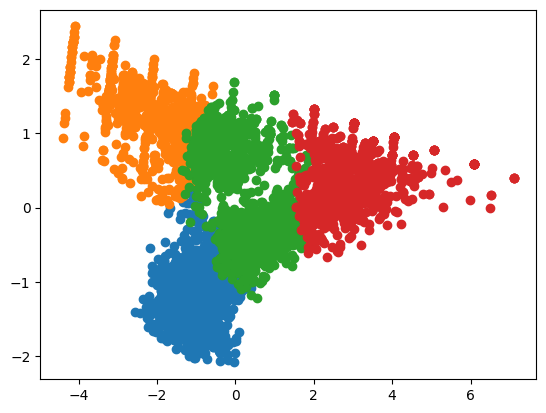

In [449]:
X = customer_clustering_sc
# PCAオブジェクトを生成（ここでは次元削減を行うので、維持する主成分の数をパラメータとして指定）
pca = PCA(n_components=2)

# fitメソッドを呼び出し、主成分を見つける
# transformメソッドで回転と次元削減を行う
x_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"] == i]
    plt.scatter(tmp[0], tmp[1])

In [450]:
# 退会顧客の傾向を把握する
# 1.クラスタリング結果に顧客行動データから退会情報を追加する
customer_clustering = pd.concat(
    [
        customer_clustering,
        customer.loc[:, ["customer_id", "is_deleted", "routine_flg"]],
    ],
    axis=1,
)
customer_clustering.head()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間,cluster,customer_id,is_deleted,routine_flg
0,4.833333,5.0,8,2,47,2,OA832399,0,1
1,5.083333,5.0,7,3,47,2,PL270116,0,1
2,4.583333,5.0,6,3,47,2,OA974876,0,1
3,4.833333,4.5,7,2,47,2,HD024127,0,1
4,3.916667,4.0,6,1,47,2,HD661448,0,1


In [451]:
# 2.クラスター毎の退会顧客数をカウントする
customer_clustering.groupby(["cluster", "is_deleted"]).count()["customer_id"]

cluster  is_deleted
0        0              791
         1              543
1        1              771
2        0             1231
         1               18
3        0              820
         1               18
Name: customer_id, dtype: int64

In [452]:
# 3.クラスター毎の定期利用フラグをカウントする
customer_clustering.groupby(["cluster", "routine_flg"]).count()["customer_id"]

cluster  routine_flg
0        0               227
         1              1107
1        0               499
         1               272
2        0                 2
         1              1247
3        0                51
         1               787
Name: customer_id, dtype: int64

In [453]:
# 翌月の利用回数の予測を行う
# 2018年5-10月の6ヶ月間のデータを用いて2018年11月の利用回数を予測する
# 1.顧客毎に月毎の利用回数を集計する
# 1-1.usedateデータをdatetime型に変換する
use_log["usedate"] = pd.to_datetime(use_log["usedate"])
# 1-2.monthデータ列を追加する
use_log["usemonth"] = use_log["usedate"].dt.strftime("%Y-%m")
use_log.head()

,log_id,customer_id,usedate,usemonth
0,L00000049012330,AS009373,2018-04-01,2018-04
1,L00000049012331,AS015315,2018-04-01,2018-04
2,L00000049012332,AS040841,2018-04-01,2018-04
3,L00000049012333,AS046594,2018-04-01,2018-04
4,L00000049012334,AS073285,2018-04-01,2018-04


In [454]:
# 1-3.顧客毎の月毎の利用データを作成する
monthly_use_log = use_log.groupby(["customer_id", "usemonth"], as_index=False).count()
monthly_use_log.drop("usedate", axis=1, inplace=True)
monthly_use_log.rename(columns={"log_id": "count"}, inplace=True)
monthly_use_log.head()

,customer_id,usemonth,count
0,AS002855,2018-04,4
1,AS002855,2018-05,5
2,AS002855,2018-06,5
3,AS002855,2018-07,5
4,AS002855,2018-08,3


In [455]:
# 2.顧客毎に予測月の利用回数とその過去6ヶ月の利用回数のデータセットを作成する
# データ取得期間が2018年4月から2019年3月なので、予測月は過去6ヶ月のデータが取れる2018年10月から2019年3月までとなる
year_months = list(monthly_use_log["usemonth"].unique())

predict_data = pd.DataFrame()

for i in range(6, len(year_months)):  # 予測月は過去6ヶ月のデータが取れる2018年10月から
    # 予測月の利用回数データのデータフレーム（tmp）を作成する
    tmp = monthly_use_log[monthly_use_log["usemonth"] == year_months[i]].copy()
    tmp.rename(columns={"count": "count_pred", "usemonth": "pred_month"}, inplace=True)

    for j in range(1, 7):
        # 予測月の過去6ヶ月の利用回数データを各列に持つデータフレーム（tmp_before）を作成する
        tmp_before = monthly_use_log[
            monthly_use_log["usemonth"] == year_months[i - j]
        ].copy()

        # 当月（予測月の前の月）を0として、何ヶ月前の利用回数かを表すカラム名をつける
        tmp_before.rename(columns={"count": f"count_{j-1}"}, inplace=True)

        # カラム名でいつの月の利用回数か判別できるようになったので、不要になったusemonthデータ列を削除する
        tmp_before.drop("usemonth", axis=1, inplace=True)

        # 予測月の利用回数データに過去の利用回数データを結合する
        tmp = pd.merge(tmp, tmp_before, how="left", on="customer_id")

    # 各予測月について作成した予測月と過去の利用回数データのデータフレームを結合する
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)

predict_data.head()

,customer_id,pred_month,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,AS002855,2018-10,3,7.0,3.0,5.0,5.0,5.0,4.0
1,AS008805,2018-10,2,2.0,5.0,7.0,8.0,NaN,NaN
2,AS009373,2018-10,5,6.0,6.0,7.0,4.0,4.0,3.0
3,AS015233,2018-10,7,9.0,11.0,5.0,7.0,7.0,NaN
4,AS015315,2018-10,4,7.0,3.0,6.0,3.0,3.0,6.0


In [456]:
# 3.過去6ヶ月間のデータに欠損があるデータを削除する
predict_data = predict_data.dropna(ignore_index=True)
predict_data.head()

,customer_id,pred_month,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,AS002855,2018-10,3,7.0,3.0,5.0,5.0,5.0,4.0
1,AS009373,2018-10,5,6.0,6.0,7.0,4.0,4.0,3.0
2,AS015315,2018-10,4,7.0,3.0,6.0,3.0,3.0,6.0
3,AS015739,2018-10,5,6.0,5.0,8.0,6.0,5.0,7.0
4,AS019860,2018-10,7,5.0,7.0,4.0,6.0,8.0,6.0


In [457]:
# 特徴となる変数(会員期間データ)を付与する
# 1.predict_dataに顧客データ（customer）のstart_dateデータを結合する
predict_data = pd.merge(
    predict_data, customer[["customer_id", "start_date"]], how="left", on="customer_id"
)
predict_data.head()

,customer_id,pred_month,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,AS002855,2018-10,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,AS009373,2018-10,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,AS015315,2018-10,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,AS015739,2018-10,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,AS019860,2018-10,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [458]:
# 2.予測月（pred_month）の初日時点での会員期間を計算する
# 2-1.予測月の初日データ（now_date）列を作成する
predict_data["now_date"] = pd.to_datetime(predict_data["pred_month"], format="%Y-%m")
predict_data.head()

,customer_id,pred_month,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date
0,AS002855,2018-10,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01
1,AS009373,2018-10,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01
2,AS015315,2018-10,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01
3,AS015739,2018-10,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01
4,AS019860,2018-10,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01


In [459]:
# 2-2.start_date列をdatetime型に変換する
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])

# 2-3.予測月までの会員期間（membership_period: now_dateとstart_dateの差分）を計算する
predict_data["membership_period"] = None

for i in range(len(predict_data)):
    delta = relativedelta(
        predict_data.loc[i, "now_date"], predict_data.loc[i, "start_date"]
    )
    predict_data.loc[i, "membership_period"] = delta.years * 12 + delta.months

predict_data.head()

,customer_id,pred_month,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,membership_period
0,AS002855,2018-10,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,AS009373,2018-10,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,AS015315,2018-10,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,AS015739,2018-10,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,AS019860,2018-10,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


In [460]:
# 来月の利用回数予測モデルを作成する
# 1.2018年4月以降に入会した顧客データに絞る
predict_data = predict_data[predict_data["start_date"] >= pd.to_datetime("20180401")]

# 2.線形回帰モデルを作成する
model = linear_model.LinearRegression()

X = predict_data[
    [
        "count_0",
        "count_1",
        "count_2",
        "count_3",
        "count_4",
        "count_5",
        "membership_period",
    ]
]
y = predict_data["count_pred"]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression()

In [461]:
# 3.精度を検証する
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6099419186766967
0.6007938543010672


In [462]:
# モデルに寄与している変数を確認する
coef = pd.DataFrame({"feature_names": X.columns, "coefficient": model.coef_})
coef

,feature_names,coefficient
0,count_0,0.326538
1,count_1,0.203764
2,count_2,0.172318
3,count_3,0.179374
4,count_4,0.056060
5,count_5,0.063121
6,membership_period,0.075321


In [463]:
# 来月の利用回数を予測する
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
X_pred = pd.DataFrame([x1, x2], columns=X.columns)

model.predict(X_pred)

array([3.79105827, 2.05918912])

In [464]:
# 顧客毎の月別の利用回数データをダンプする
if not os.path.exists("output"):
    # ディレクトリが存在しない場合、ディレクトリを作成する
    os.makedirs("output")

monthly_use_log.to_csv("output/use_log_months.csv", index=False)